In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ocular-disease-recognition-odir5k/full_df.csv
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/3419_left.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/4176_right.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/3370_left.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/1255_right.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/660_left.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/484_right.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/4221_right.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/2396_left.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/543_left.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/3017_left.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/1482_left.jpg
/kaggle/input/ocular-disease-recognit

In [2]:
#this is all the intro imports needed to run the code
import numpy as np
import pandas as pd
import cv2
import random
import matplotlib.pyplot as plt
import os
from tqdm.auto import tqdm

In [3]:
#this allows for the CSV overview to be read into the program
df = pd.read_csv("/kaggle/input/ocular-disease-recognition-odir5k/full_df.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         6392 non-null   int64 
 1   Patient Age                6392 non-null   int64 
 2   Patient Sex                6392 non-null   object
 3   Left-Fundus                6392 non-null   object
 4   Right-Fundus               6392 non-null   object
 5   Left-Diagnostic Keywords   6392 non-null   object
 6   Right-Diagnostic Keywords  6392 non-null   object
 7   N                          6392 non-null   int64 
 8   D                          6392 non-null   int64 
 9   G                          6392 non-null   int64 
 10  C                          6392 non-null   int64 
 11  A                          6392 non-null   int64 
 12  H                          6392 non-null   int64 
 13  M                          6392 non-null   int64 
 14  O       

In [4]:
df.head(5)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [5]:
# Function to check if a given text contains the word "cataract"
def has_cataract(text):
    if "cataract" in text:
        return 1
    else:
        return 0

In [6]:
# Applying has_cataract() function to column values:
# Left-Diagnostic Keywords and Right-Diagnostic Keywords
df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))

In [7]:
# Transfering image filenames 
left_cataract = df.loc[(df.C ==1) & (df.left_cataract == 1)]["Left-Fundus"].values
right_cataract = df.loc[(df.C ==1) & (df.right_cataract == 1)]["Right-Fundus"].values

left_normal = df.loc[(df.C ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(300,random_state=42).values
right_normal = df.loc[(df.C ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(300,random_state=42).values

In [8]:
left_cataract[:10], left_normal[:10]

(array(['0_left.jpg', '81_left.jpg', '103_left.jpg', '119_left.jpg',
        '254_left.jpg', '294_left.jpg', '330_left.jpg', '448_left.jpg',
        '465_left.jpg', '477_left.jpg'], dtype=object),
 array(['3332_left.jpg', '4059_left.jpg', '69_left.jpg', '2415_left.jpg',
        '4176_left.jpg', '2711_left.jpg', '4614_left.jpg', '3174_left.jpg',
        '2862_left.jpg', '2424_left.jpg'], dtype=object))

In [9]:
# Cancatenating left_images and right_images to single array variable
cataract = np.concatenate((left_cataract,right_cataract), axis=0)
normal = np.concatenate((left_normal,right_normal), axis=0)

In [10]:
len(cataract), len(normal)

(594, 600)

In [11]:
import torch
from torch import nn
from torch.utils.data import Dataset, ConcatDataset, TensorDataset, DataLoader

print(torch.__version__)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

2.1.2+cpu
cpu


In [12]:
class CustomDataset(Dataset):
  def __init__(self, image_category, label, dataset_dir, image_size=224):
    self.image_category = image_category
    self.label = label
    self.dataset_dir = dataset_dir
    self.image_size = image_size
    self.data = self.create_dataset()

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    img, label = self.data[idx]
    return img, label

  def create_dataset(self):
    dataset = []
    dataset_label = []
    for img in tqdm(self.image_category):
      image_path = os.path.join(self.dataset_dir, img)
      try:
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        # Convert BGR to RGB 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (self.image_size, self.image_size))
      except:
        continue

      dataset.append([np.array(image), np.array(self.label)])
    random.shuffle(dataset)
    return dataset

In [13]:
dataset_cataract = CustomDataset(image_category = cataract,
                                 label = 1,
                                 dataset_dir = "/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/",
                                 image_size = 224)

dataset_normal = CustomDataset(normal, 0, "/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/", 224)

  0%|          | 0/594 [00:00<?, ?it/s]

[ WARN:0@6.524] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/2102_left.jpg'): can't open/read file: check file path/integrity
[ WARN:0@7.952] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/2231_left.jpg'): can't open/read file: check file path/integrity
[ WARN:0@8.083] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/2244_left.jpg'): can't open/read file: check file path/integrity
[ WARN:0@8.131] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/2251_left.jpg'): can't open/read file: check file path/integrity
[ WARN:0@11.746] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/1456_right.jpg'): can't open/read file: check file path/integrity
[ WARN:0@12.455] global load

  0%|          | 0/600 [00:00<?, ?it/s]

In [14]:
dataset = ConcatDataset([dataset_cataract, dataset_normal])

print("Combined dataset length:", len(dataset))

Combined dataset length: 1188


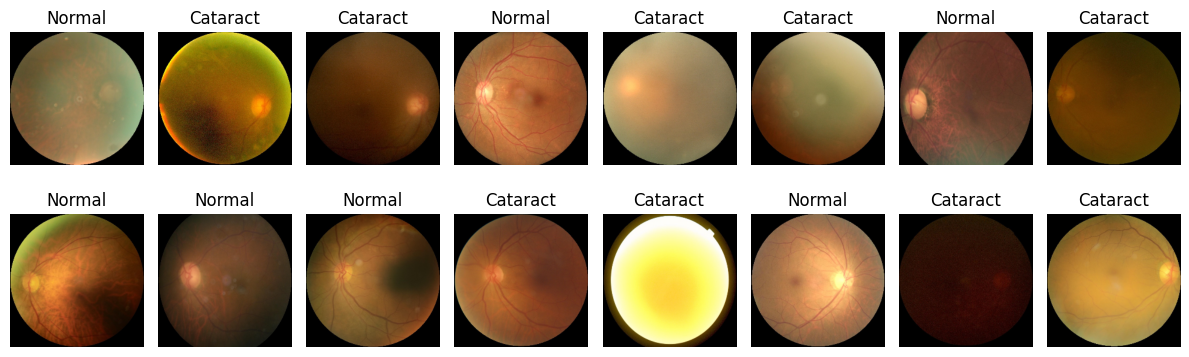

In [15]:
plt.figure(figsize=(12, 4))
rows, cols = 2, 8
for i in range(1, rows*cols + 1):
  sample = random.choice(range(len(dataset)))
  image = dataset[sample][0]
  category = dataset[sample][1]

  label = "Normal" if category == 0 else "Cataract"

  plt.subplot(rows, cols, i)
  plt.imshow(image)
  plt.title(label)
  plt.axis(False);
plt.tight_layout()

In [16]:
dataset[0][0].shape

(224, 224, 3)

In [17]:
# Reshaping image dataset to load in tensor
X = np.array([i[0] for i in dataset]).reshape(-1, 224, 224, 3)
y = np.array([i[1] for i in dataset])

In [18]:
# Conversion into tensors from arrays
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.long)

X[0], y[:10]

(tensor([[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]]),
 tensor([1, 

In [19]:
""" Train/Test Split"""

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    shuffle = True,
                                                    random_state = 42)

len(X_train), len(X_test), y_train[:10]

(950, 238, tensor([1, 0, 0, 1, 0, 1, 1, 0, 1, 1]))

In [20]:
X_train.shape

torch.Size([950, 224, 224, 3])

In [21]:
# Permute the color channel index to front
X_train, X_test = X_train.permute(0, 3, 1, 2), X_test.permute(0, 3, 1, 2)

In [22]:
# Turn datasets into batches
BATCH_SIZE = 32

train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(dataset = train_dataset,
                              batch_size = BATCH_SIZE,
                              shuffle = False)      # Shuffle false cuz already shuffled using sklearn->train_test_spilt

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(dataset = test_dataset,
                             batch_size = BATCH_SIZE,
                             shuffle = False)

len(train_dataloader), len(test_dataloader)

(30, 8)

In [23]:
class CataractModel(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super(CataractModel, self).__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(input_shape, hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.BatchNorm2d(hidden_units)  # Batch normalization for stabilization
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(hidden_units, 2 * hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(2 * hidden_units, 2 * hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.BatchNorm2d(2 * hidden_units)
    )
    self.conv_block_3 = nn.Sequential(
        nn.Conv2d(2 * hidden_units, 4 * hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(4 * hidden_units, output_shape, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.BatchNorm2d(output_shape)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28 * output_shape, 512),
        nn.ReLU(),
        nn.Dropout(0.5),  # Dropout for regularization
        nn.Linear(512, output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.conv_block_3(x)
    x = self.classifier(x)
    return x

In [24]:
model = CataractModel(3, 10, 2).to(device)   # (3, 10, 2) -> (Color_channel, hidden_units, output_shape)
model, next(model.parameters()).device

(CataractModel(
   (conv_block_1): Sequential(
     (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (3): ReLU()
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (5): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (conv_block_2): Sequential(
     (0): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (3): ReLU()
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (5): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (conv_block_3): Sequential(
     (0): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Conv2d(40, 2, kernel_size=(3, 3), stride=(1, 1), padding=

In [25]:
!pip install torchmetrics

In [26]:
# Import Accuracy
from torchmetrics import Accuracy

torchmetrics_accuracy = Accuracy(task = "binary",
                                 num_classes = 2).to(device)

In [27]:
# Setting up loss_fn and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.001)

In [28]:
# Train and Test function
def train_step(model, data_loader, loss_fn, optimizer, accuracy, device):
  train_loss, train_acc = 0, 0

  model.to(device)
  train_losses = []
  train_accuracies = []
  for batch, (X, y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += torchmetrics_accuracy(y,
                                       y_pred.argmax(dim = 1)) * 100
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  train_losses.append(train_loss.item())
  train_accuracies.append(train_acc.item())
  print(f'Train loss: {train_loss:.4f} ---- Train acc: {train_acc:.2f}%')
  return train_losses, train_accuracies

def test_step(model, data_loader, loss_fn, optimizer, accuracy, device):
  test_loss, test_acc = 0, 0
  model.to(device)
  model.eval()
  test_losses = []
  test_accuracies = []

  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)
      test_pred = model(X)
      loss = loss_fn(test_pred, y)
      test_loss += loss
      test_acc += torchmetrics_accuracy(y,
                                        test_pred.argmax(dim = 1)) * 100
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    test_losses.append(test_loss.item())
    test_accuracies.append(test_acc.item())
    print(f'Test loss: {test_loss:.4f} ---- Test acc: {test_acc:.2f}%')
  return test_losses, test_accuracies

In [29]:
torch.manual_seed(42)

epochs = 10
train_losses_history = []
train_accuracies_history = []
test_losses_history = []
test_accuracies_history = []

for epoch in tqdm(range(epochs)):
  print(f'Epoch: {epoch}')
  train_losses, train_accuracies = train_step(model, train_dataloader, loss_fn, optimizer,
                                              torchmetrics_accuracy, device)
  test_losses, test_accuracies = test_step(model, test_dataloader, loss_fn, optimizer,
                                           torchmetrics_accuracy, device)
  # Calculate avg. loss and accuracy
  avg_train_loss = sum(train_losses) / len(train_losses)
  avg_train_accuracy = sum(train_accuracies) / len(train_accuracies)
  avg_test_loss = sum(test_losses) / len(test_losses)
  avg_test_accuracy = sum(test_accuracies) / len(test_accuracies)

  # Append train, test metrics for plotting curves
  train_losses_history.append(avg_train_loss)
  train_accuracies_history.append(avg_train_accuracy)
  test_losses_history.append(avg_test_loss)
  test_accuracies_history.append(avg_test_accuracy)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
Train loss: 0.7154 ---- Train acc: 57.59%
Test loss: 0.6823 ---- Test acc: 54.80%
Epoch: 1
Train loss: 0.6645 ---- Train acc: 60.62%
Test loss: 0.6686 ---- Test acc: 54.69%
Epoch: 2
Train loss: 0.5434 ---- Train acc: 72.62%
Test loss: 0.3731 ---- Test acc: 90.62%
Epoch: 3
Train loss: 0.3523 ---- Train acc: 86.57%
Test loss: 0.3888 ---- Test acc: 84.21%
Epoch: 4
Train loss: 0.3153 ---- Train acc: 87.09%
Test loss: 0.2479 ---- Test acc: 89.12%
Epoch: 5
Train loss: 0.1915 ---- Train acc: 92.56%
Test loss: 0.1998 ---- Test acc: 91.80%
Epoch: 6
Train loss: 0.1726 ---- Train acc: 93.85%
Test loss: 0.1804 ---- Test acc: 92.47%
Epoch: 7
Train loss: 0.1655 ---- Train acc: 94.17%
Test loss: 0.1856 ---- Test acc: 92.08%
Epoch: 8
Train loss: 0.1227 ---- Train acc: 95.52%
Test loss: 0.1433 ---- Test acc: 93.75%
Epoch: 9
Train loss: 0.1087 ---- Train acc: 96.56%
Test loss: 0.1466 ---- Test acc: 94.81%


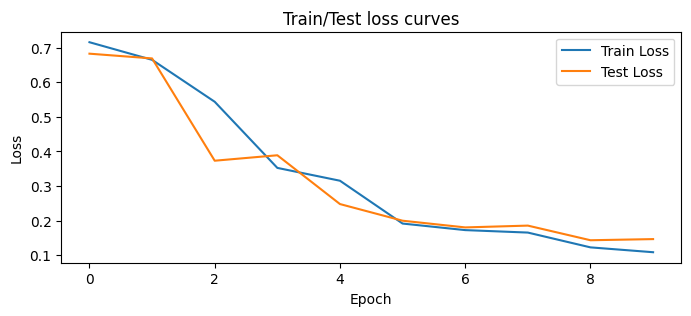

In [30]:
# Plot loss curves
epoch = np.arange(0, len(train_losses_history))

plt.figure(figsize=(8, 3))
plt.plot(epoch, train_losses_history, label="Train Loss")
plt.plot(epoch, test_losses_history, label="Test Loss")
plt.title("Train/Test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend();

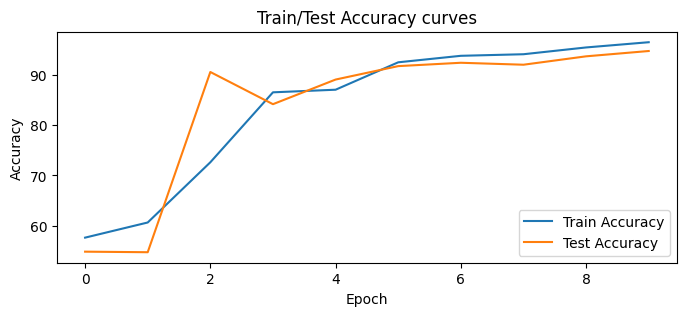

In [31]:
# Plot accuracy curves
plt.figure(figsize=(8, 3))
plt.plot(epoch, train_accuracies_history, label="Train Accuracy")
plt.plot(epoch, test_accuracies_history, label="Test Accuracy")
plt.title("Train/Test Accuracy curves")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend();

In [32]:
def make_predictions(model, data, device):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample, dim = 0).to(device)
      pred_logit = model(sample)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim = 0)
      pred_probs.append(pred_prob.cpu())

  return torch.stack(pred_probs)

In [33]:
import random
# random.seed(42)

test_samples = []
test_labels = []

for sample, label in random.sample(list(test_dataset), k = 20):
  test_samples.append(sample)
  test_labels.append(label)

In [34]:
test_samples[0].shape

torch.Size([3, 224, 224])

In [35]:
# Make Predictions
pred_probs = make_predictions(model,
                              test_samples,
                              device)

# Convert prediction proabbilities to labels
pred_classes = pred_probs.argmax(dim = 1)
print(pred_classes, test_labels, sep = '\n')

tensor([1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1])
[tensor(1), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(1), tensor(1), tensor(1), tensor(1), tensor(0), tensor(1), tensor(0), tensor(1), tensor(0), tensor(0), tensor(0), tensor(1)]


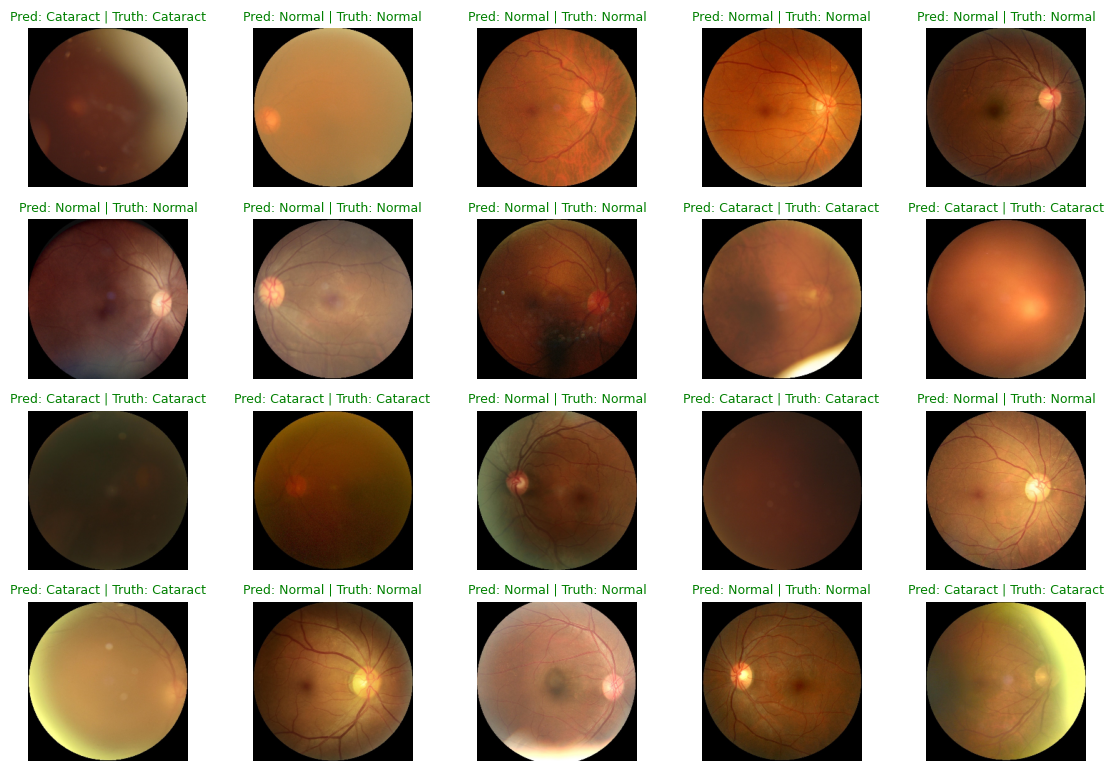

In [36]:
# Plot predictions
plt.figure(figsize=(14, 12))
nrows, ncols = 5, 5
for i, sample in enumerate(test_samples):
  class_name = np.array(['Normal', 'Cataract'])
  plt.subplot(nrows, ncols, i + 1)
  # Convert PyTorch tensor to NumPy array
  normalized_sample = sample.permute(1, 2, 0).numpy()
  normalized_sample = normalized_sample / 255.0  # Normalize pixel values to [0, 1]
  plt.imshow(normalized_sample)
  # print(normalized_sample.shape)
  pred_label = class_name[pred_classes[i]]
  truth_label = class_name[test_labels[i]]
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check equality between pred and truth and change color of title
  if pred_label == truth_label:
      plt.title(title_text, fontsize=9, c="g")
  else:
      plt.title(title_text, fontsize=9, c="r")

  plt.axis(False)
plt.show()

In [37]:
# Make prediciton with trained model for confusion matrix
y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader,
                   desc = "Making predictions...\t"):
    X, y = X.to(device), y.to(device)
    y_logits = model(X)
    y_pred = torch.softmax(y_logits.squeeze(), dim = 0).argmax(dim = 1 )
    y_preds.append(y_pred.cpu())

# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor[:10], len(y_pred_tensor)

Making predictions...	:   0%|          | 0/8 [00:00<?, ?it/s]

(tensor([1, 0, 0, 1, 0, 1, 0, 0, 1, 1]), 238)

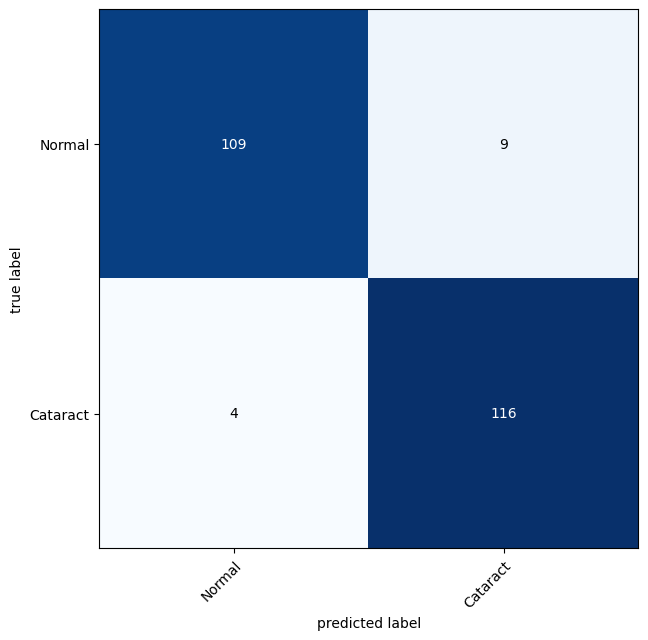

In [38]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes = len(class_name), task = 'binary')
# print(y_pred_tensor, test_data.targets)
confmat_tensor = confmat(preds = y_pred_tensor,
                         target = y_test)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat = confmat_tensor.numpy(),
    class_names = class_name,
    figsize = (10, 7)
);

In [39]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

# Create model save path
MODEL_NAME = "EyeCataractDetectModel.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/EyeCataractDetectModel.pth


In [40]:
loaded_model = CataractModel(3, 10, 2)

loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

print(f"Loaded model:\n{loaded_model}")
print(f"Model on device:\n{next(loaded_model.parameters()).device}")
# loaded_model = loaded_model.to('cpu')     # For model to load in cpu and check inference

Loaded model:
CataractModel(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_block_3): Sequential(
    (0): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(40, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [41]:
loaded_pred_probs = make_predictions(loaded_model,
                                     test_samples,
                                     device)

loaded_pred_classes = loaded_pred_probs.argmax(dim = 1)

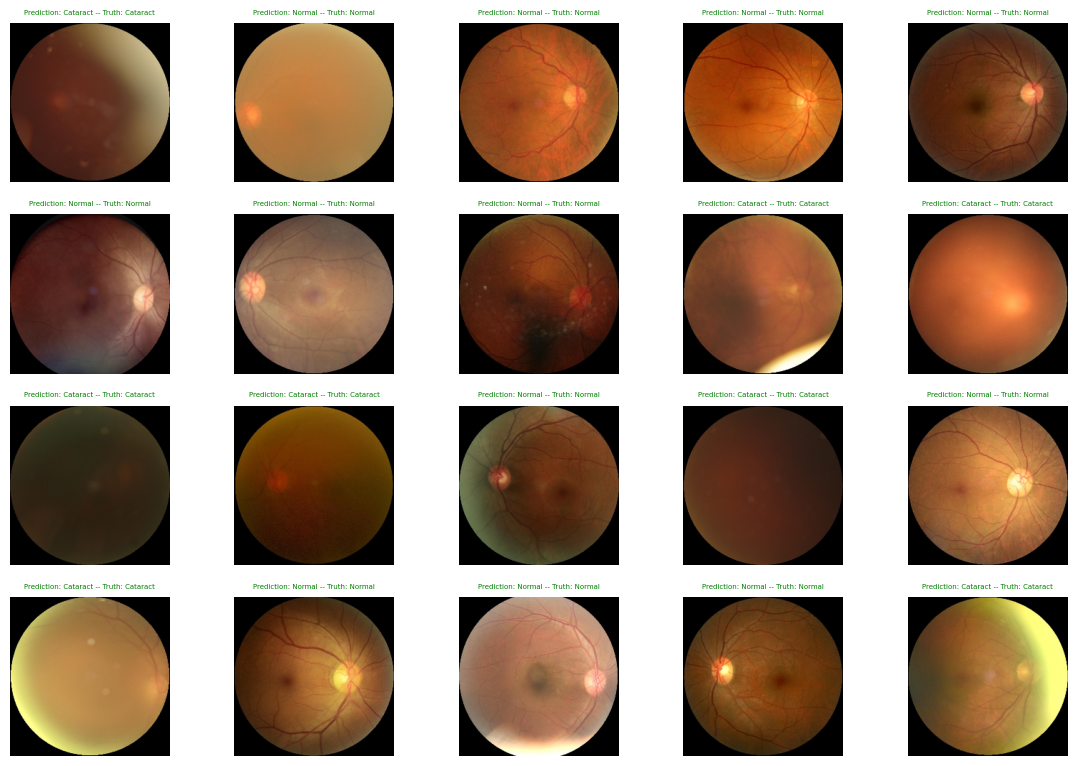

In [42]:
plt.figure(figsize=(14, 12))
nrows, ncols = 5, 5

for i, sample in enumerate(test_samples):
  class_name = np.array(['Normal', 'Cataract'])
  plt.subplot(nrows, ncols, i + 1)
  normalized_sample = sample.permute(1, 2, 0).numpy()
  normalized_sample = normalized_sample / 255.0
  plt.imshow(normalized_sample)
  # print(normalized_sample.shape)
  pred_label = class_name[loaded_pred_classes[i]]
  truth_label = class_name[test_labels[i]]
  title_text = f"Prediction: {pred_label} -- Truth: {truth_label}"

  if pred_label == truth_label:
      plt.title(title_text, fontsize=5, c="g")
  else:
      plt.title(title_text, fontsize=9, c="r")

  plt.axis(False);

In [43]:
from sklearn.metrics import accuracy_score, roc_auc_score
accuracy = accuracy_score(y_test, y_pred_tensor)
# Calculate AUC

auc = roc_auc_score(y_test, y_pred_tensor)

print(f"accuracy: {accuracy:.4f}")
print(f"AUC: {auc:.4f}")

accuracy: 0.9454
AUC: 0.9452


In [44]:
from sklearn import metrics
import os

def plot_uni_roc_curve (y_true, y_preds_prob, clf_name = None, save_name = False):
  plt.figure(figsize=(6,6))
  fpr, tpr, threshold = metrics.roc_curve(y_true, y_preds_prob)
  roc_auc = metrics.auc(fpr, tpr)

  plt.title('Classifier.Performance -- %s' %(clf_name))
  plt.plot(fpr, tpr,'b', label = 'AUC = %0.5f' % roc_auc)
  plt. legend (loc = 'lower right')
  plt.plot([0, 1], [0, 1], 'r--')
  plt.xlim([-0.01, 1.01])
  plt.ylim([-0.01, 1.01])
  plt.ylabel('True Positive Rate (Sensitivity)')
  plt.xlabel('False Positive Rate  (1 - Specificity) ')


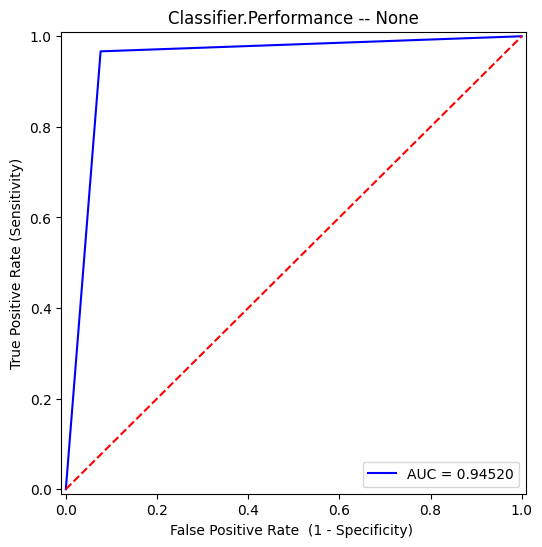

In [45]:
roc_lr = plot_uni_roc_curve(y_test, y_pred_tensor, save_name="roc_lr")